In [2]:
%matplotlib widget
import matplotlib.pyplot as plt

import torch

import efield
import test_efield

from importlib import reload

100%|██████████| 100/100 [00:19<00:00,  5.17it/s]


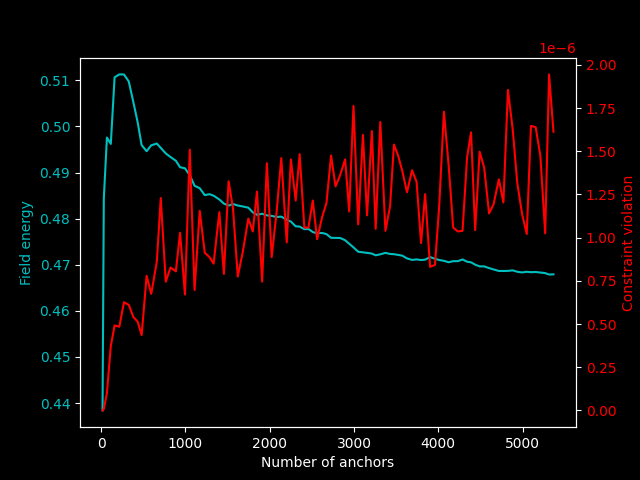

In [5]:
reload(efield)


def dipole(
    box1: efield.Box,
    box2: efield.Box,
    box1_potential: float,
    box2_potential: float,
    universe: efield.Box,
) -> efield.Potential:
    box1_locations3d = box1.grid(2, 2, 2)
    box2_locations3d = box2.grid(2, 2, 2)

    conductor_locations3d = torch.vstack((box1_locations3d, box2_locations3d))
    conductor_potentials = torch.tensor(
        [box1_potential] * len(box1_locations3d)
        + [box2_potential] * len(box2_locations3d),
    )

    return efield.fit_radial_basis_function_potential(
        universe, conductor_locations3d, conductor_potentials
    )


box1 = efield.Box(-0.03, 0.03, -0.03, 0.03, -0.37, -0.43)
box1_potential = -1.0
box2 = efield.Box(-0.03, 0.03, -0.03, 0.03, 0.37, 0.43)
box2_potential = 1.0
universe = efield.Box(-0.7, 0.7, -0.7, 0.7, -1, 1)
potential = dipole(box1, box2, box1_potential, box2_potential, universe)

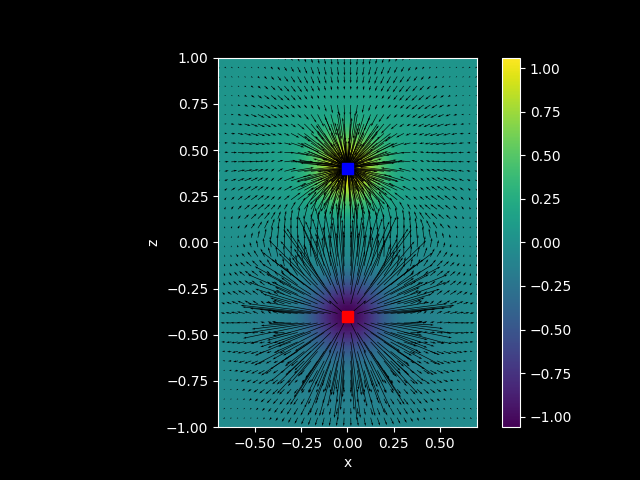

In [6]:
def show_xz_cross_section(
    box1: efield.Box,
    box2: efield.Box,
    universe: efield.Box,
    potential: efield.Potential,
    y: float,
):
    fig, ax = plt.subplots(1, 1)

    # Show the potential function as a potential heat map.
    X, Z = torch.meshgrid(
        torch.linspace(universe.xmin, universe.xmax, 100),
        torch.linspace(universe.zmin, universe.zmax, 100),
        indexing="xy",
    )
    xyz = torch.stack((X.flatten(), y + 0 * X.flatten(), Z.flatten())).T
    if True:
        # Show the potential function.
        V = potential(xyz)
    elif False:
        # Show the local energy.
        Vx, Vy, Vz = potential.field(xyz)
        V = Vx**2 + Vy**2 + Vz**2
    else:
        # Show the magnitude of the laplacian.
        V = potential.laplacian(xyz).abs().log()

    img = ax.imshow(
        V.reshape(X.shape).detach(),
        extent=(universe.xmin, universe.xmax, universe.zmin, universe.zmax),
        origin="lower",
    )

    # Show the field as a quiver plot.
    X_field, Z_field = torch.meshgrid(
        torch.linspace(universe.xmin, universe.xmax, 40),
        torch.linspace(universe.zmin, universe.zmax, 40),
        indexing="xy",
    )
    xyz_field = torch.stack(
        (X_field.flatten(), X_field.flatten() * 0 + y, Z_field.flatten())
    ).T
    Vx, _, Vz = potential.field(xyz_field).detach().numpy()
    ax.quiver(
        xyz_field[:, 0], xyz_field[:, 2], Vx, Vz, angles="xy", units="xy", scale=10
    )

    fig.colorbar(img, ax=ax)

    ax.add_artist(
        plt.Rectangle(
            (box1.xmin, box1.zmin),
            box1.xmax - box1.xmin,
            box1.zmax - box1.zmin,
            color="r",
        )
    )
    ax.add_artist(
        plt.Rectangle(
            (box2.xmin, box2.zmin),
            box2.xmax - box2.xmin,
            box2.zmax - box2.zmin,
            color="b",
        ),
    )
    ax.set_xlabel("x")
    ax.set_ylabel("z")


show_xz_cross_section(box1, box2, universe, potential, 0)

Compare recovered field against the field predicted by Coulomb's law.


The latter field assumes the charges are known. But in the actual problem we're
solving, the charges are not known. Only their potential is known. To compute
the Coulomb potential, we plug in the potential at the charge as ther charge
itself.  So this comparison is very subjective.

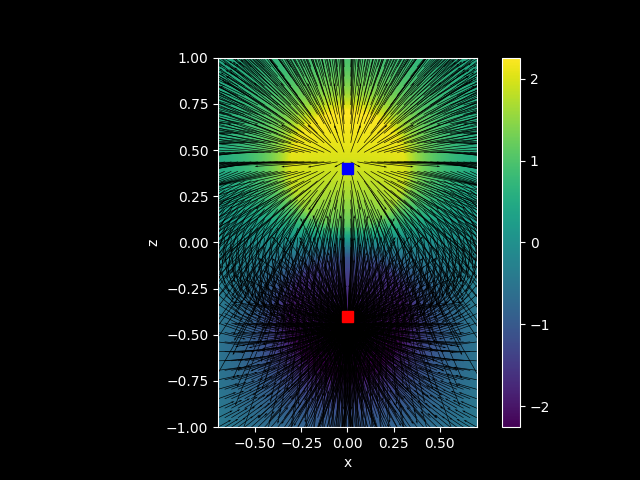

In [7]:
multipole_potential = efield.CoulombPotential(
    torch.stack((box1.center(), box2.center())),
    torch.tensor((box1_potential, box2_potential)),
    None,
)

show_xz_cross_section(box1, box2, universe, multipole_potential, 0)

Visualize the recoverdd field in 3D:

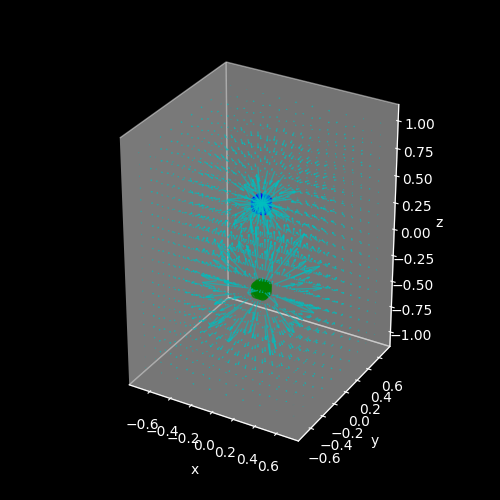

In [8]:
def show_field(
    box1: efield.Box,
    box2: efield.Box,
    universe: efield.Box,
    potential: efield.Potential,
):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection="3d")

    box1_locations3d = box1.grid(3, 3, 3)
    ax.scatter(
        box1_locations3d[:, 0],
        box1_locations3d[:, 1],
        box1_locations3d[:, 2],
        s=50,
        color="g",
    )
    box2_locations3d = box2.grid(3, 3, 3)
    ax.scatter(
        box2_locations3d[:, 0],
        box2_locations3d[:, 1],
        box2_locations3d[:, 2],
        s=50,
        color="b",
    )
    xyz = universe.grid(10, 10, 20)

    Vx, Vy, Vz = potential.field(xyz).detach()
    ax.quiver(
        xyz[:, 0],
        xyz[:, 1],
        xyz[:, 2],
        Vx,
        Vy,
        Vz,
        lw=1,
        length=0.1,
        alpha=0.6,
        color="c",
    )
    ax.grid(False)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.axis("square")


show_field(box1, box2, universe, potential)